In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [5]:
from funcs_var import *

---

### Data Collection

#### short term interest rate

In [6]:
stir = pd.read_csv('var/short_term_int_rate_m.csv')

In [7]:
stir = stir[['TIME', 'Value']].copy()

#### inflation rate

In [8]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')

In [9]:
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()

In [10]:
ir = ir[:-9]

In [11]:
ir = [float(ir[i]) for i in range(len(ir))]

In [12]:
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))

In [13]:
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

#### unemployment rate

In [14]:
ur = pd.read_csv('var/unemployment_rate_m.csv')

In [15]:
ur = ur[['TIME', 'Value']].copy()

#### Make full df

In [16]:
ur[ur['TIME']=='1964-06']

,TIME,Value
113,1964-06,5.2


In [17]:
ir[ir['TIME']=='1964-6']

,TIME,Value
605,1964-6,1.3


In [18]:
stir.head()

,TIME,Value
0,1964-06,3.86
1,1964-07,3.87
2,1964-08,3.85
3,1964-09,3.87
4,1964-10,3.94


In [19]:
df_var = pd.concat([stir, 
           pd.DataFrame(ir.iloc[605:, 1]).reset_index(drop=True), 
           pd.DataFrame(ur.iloc[113:, 1]).reset_index(drop=True)], 
          axis=1)
df_var.columns = ['TIME','stir', 'infr', 'umpr']

---

### Stationarity part

In [20]:
df_var.head()

,TIME,stir,infr,umpr
0,1964-06,3.86,1.3,5.2
1,1964-07,3.87,1.3,4.9
2,1964-08,3.85,1,5.0
3,1964-09,3.87,1.3,5.1
4,1964-10,3.94,1,5.1


In [21]:
df_var = df_var.iloc[:-5, :].copy()

In [22]:
df_var_t = df_var.copy()
df_var_t['TIME'] = pd.to_datetime(df_var_t['TIME'])
df_var_t.index = df_var_t['TIME']

Results of Dickey-Fuller Test:
Test Statistic                  -2.169757
p-value                          0.217404
#Lags Used                      19.000000
Number of Observations Used    609.000000
Critical Value (10%)            -2.569304
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
dtype: float64


Results of KPSS Test:
Test Statistic            1.542907
p-value                   0.010000
#Lags Used               20.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


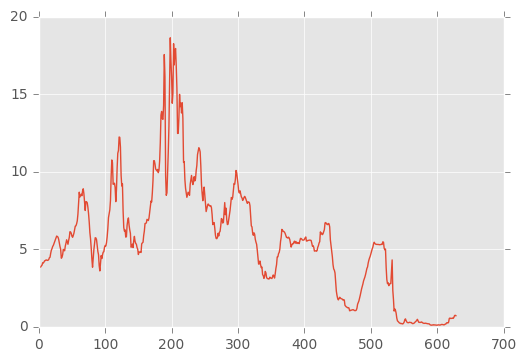

In [23]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.026327
p-value                          0.032508
#Lags Used                      18.000000
Number of Observations Used    610.000000
Critical Value (10%)            -2.569300
Critical Value (1%)             -3.441116
Critical Value (5%)             -2.866290
dtype: float64


Results of KPSS Test:
Test Statistic            1.154627
p-value                   0.010000
#Lags Used               20.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


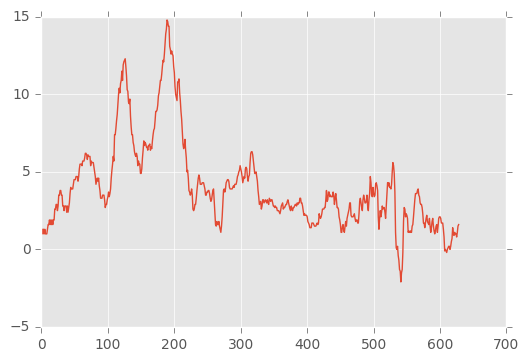

In [24]:
test_stationarity(df_var_t['infr'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.355673
p-value                          0.012566
#Lags Used                       6.000000
Number of Observations Used    622.000000
Critical Value (10%)            -2.569251
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
dtype: float64


Results of KPSS Test:
Test Statistic            0.24785
p-value                   0.10000
#Lags Used               20.00000
Critical Value (2.5%)     0.57400
Critical Value (10%)      0.34700
Critical Value (1%)       0.73900
Critical Value (5%)       0.46300
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


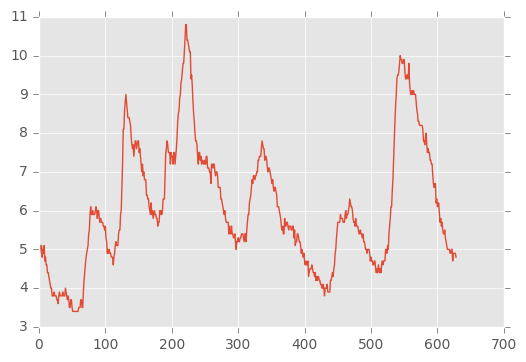

In [25]:
test_stationarity(df_var_t['umpr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                  -5.337747
p-value                          0.000005
#Lags Used                      18.000000
Number of Observations Used    609.000000
Critical Value (10%)            -2.569304
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
dtype: float64


Results of KPSS Test:
Test Statistic            0.082104
p-value                   0.100000
#Lags Used               19.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


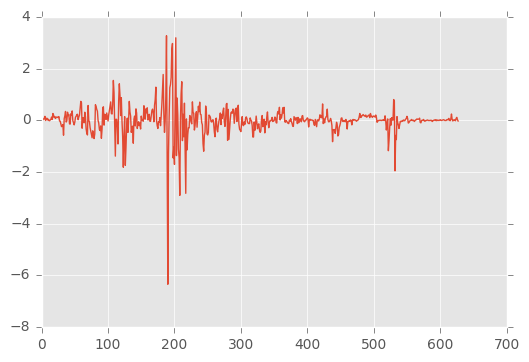

In [26]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -6.032762e+00
p-value                        1.405130e-07
#Lags Used                     1.400000e+01
Number of Observations Used    6.130000e+02
Critical Value (10%)          -2.569287e+00
Critical Value (1%)           -3.441063e+00
Critical Value (5%)           -2.866266e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.070892
p-value                   0.100000
#Lags Used               19.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


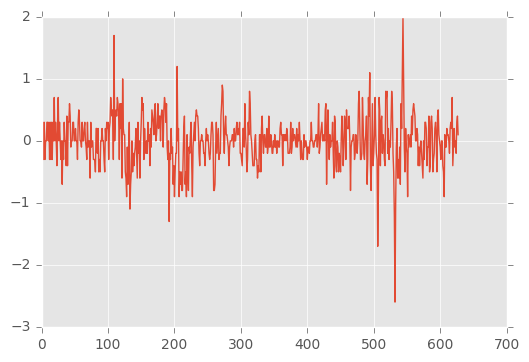

In [27]:
test_stationarity(diff_series(df_var_t['infr']))

Results of Dickey-Fuller Test:
Test Statistic                -5.880016e+00
p-value                        3.094187e-07
#Lags Used                     1.100000e+01
Number of Observations Used    6.160000e+02
Critical Value (10%)          -2.569275e+00
Critical Value (1%)           -3.441010e+00
Critical Value (5%)           -2.866243e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.055131
p-value                   0.100000
#Lags Used               19.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


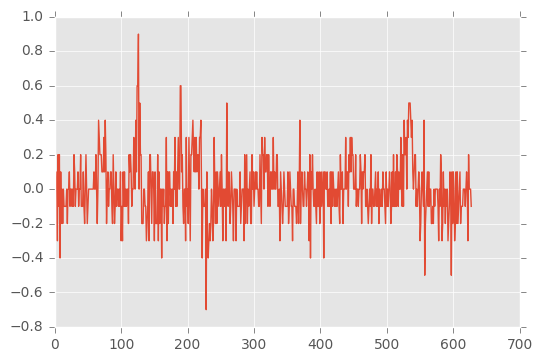

In [28]:
test_stationarity(diff_series(df_var_t['umpr']))

In [29]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [30]:
train = df_var_t_diff.iloc[:-6, 1:]
test = df_var_t_diff.iloc[-6:, 1:]

train_real = df_var_t.iloc[:-6, 1:]
test_real = df_var_t.iloc[-6:, 1:]

In [31]:
LAG = 4

In [32]:
STEPS = 6

### VAR

In [33]:
def var_model(train, steps, lags, years=None):
    df = np.array(train)
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [34]:
#years=train['TIME'][2:-6].reset_index(drop=True)
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:])

In [35]:
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'rmse': 0.079179122554401848, 'mae': 0.061910114778529625, 'mse': 0.0062693334484849872}
{'rmse': 0.24495957610350294, 'mae': 0.20861734227945836, 'mse': 0.060005193924807847}
{'rmse': 0.15724699534328532, 'mae': 0.1095642351431733, 'mse': 0.024726617544491198}


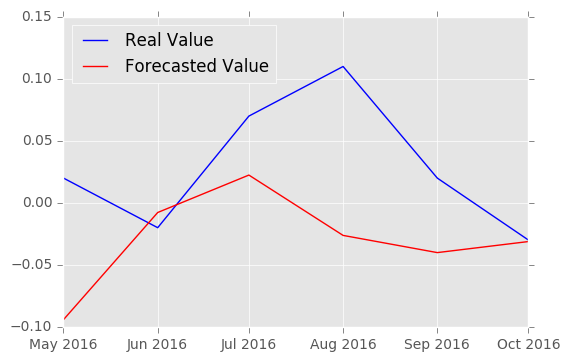

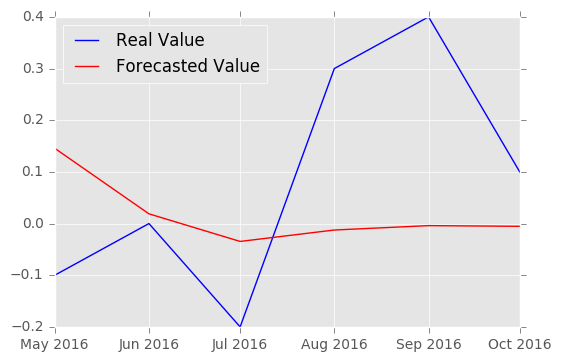

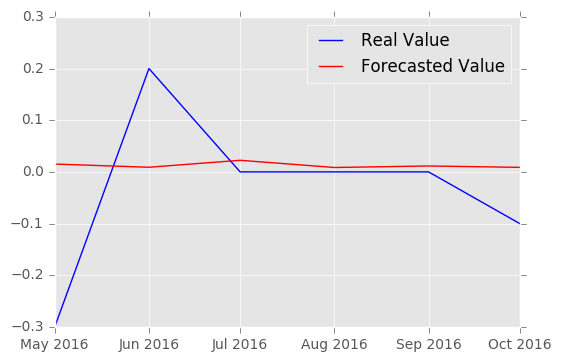

In [36]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])

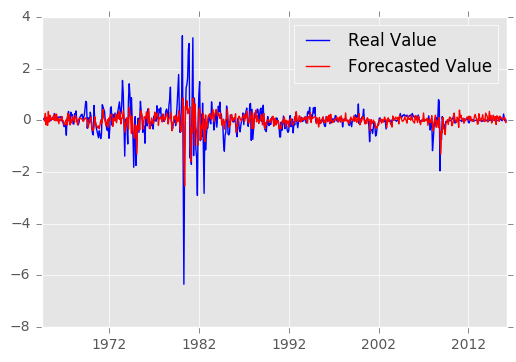

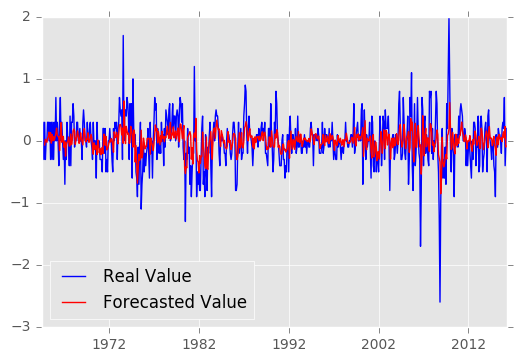

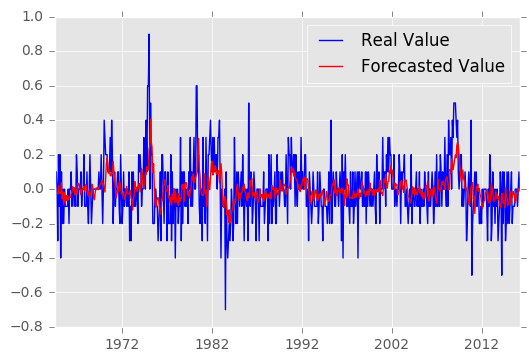

In [37]:
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

In [38]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])

In [39]:
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])

In [40]:
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))

{'rmse': 0.24744201299484295, 'mae': 0.22401056403878558, 'mse': 0.06122754979494003}
{'rmse': 0.30677102817605834, 'mae': 0.28932943918953408, 'mse': 0.094108463728195993}
{'rmse': 0.20967960960611834, 'mae': 0.19712917567385282, 'mse': 0.043965538684574194}


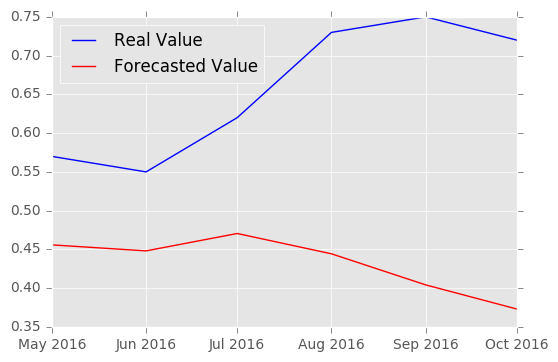

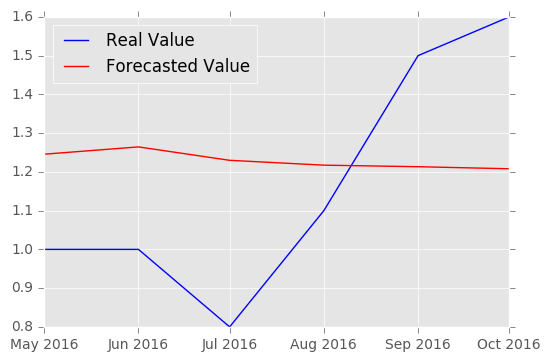

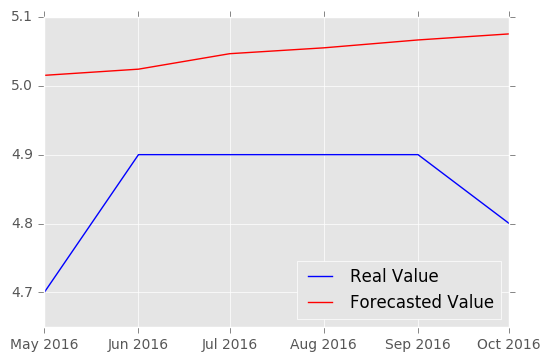

In [41]:
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])

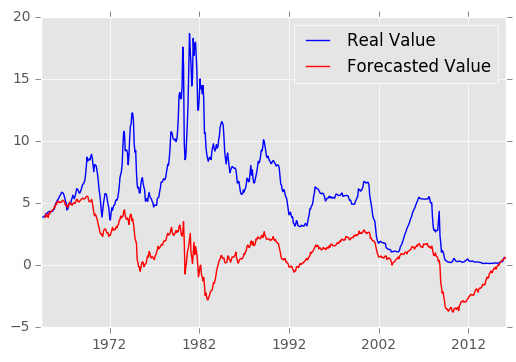

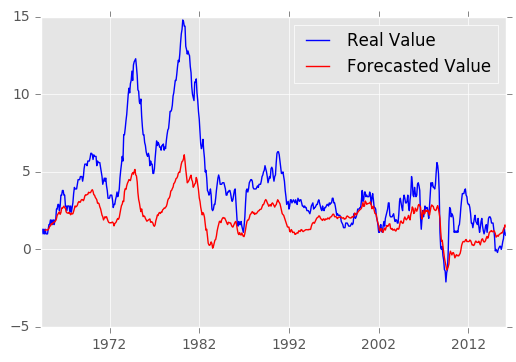

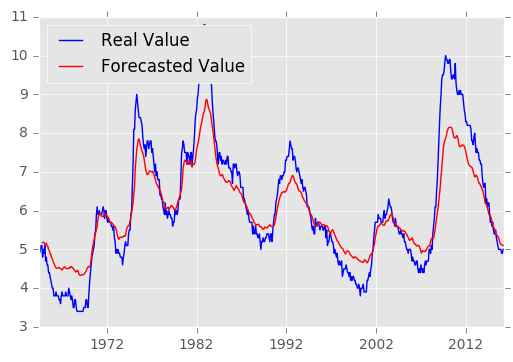

In [42]:
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

### ANN

In [43]:
df_nn = nn_transform(train, n=LAG)

In [44]:
train_nn_x = df_nn.iloc[:, 3:].copy()
train_nn_y = df_nn.iloc[:, :3].copy()

Первый запуск модели для проверки ее устойчивости

In [45]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [46]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100):
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

In [47]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=6, model=nn, 
                     years=train_nn_y.index, 
                     epoch=100)

Epoch 1/100
1s - loss: 0.1743
Epoch 2/100
0s - loss: 0.1685
Epoch 3/100
0s - loss: 0.1667
Epoch 4/100
0s - loss: 0.1630
Epoch 5/100
0s - loss: 0.1600
Epoch 6/100
0s - loss: 0.1568
Epoch 7/100
0s - loss: 0.1541
Epoch 8/100
0s - loss: 0.1514
Epoch 9/100
0s - loss: 0.1490
Epoch 10/100
0s - loss: 0.1474
Epoch 11/100
0s - loss: 0.1462
Epoch 12/100
0s - loss: 0.1448
Epoch 13/100
0s - loss: 0.1438
Epoch 14/100
0s - loss: 0.1438
Epoch 15/100
0s - loss: 0.1428
Epoch 16/100
0s - loss: 0.1423
Epoch 17/100
0s - loss: 0.1417
Epoch 18/100
0s - loss: 0.1409
Epoch 19/100
0s - loss: 0.1407
Epoch 20/100
0s - loss: 0.1400
Epoch 21/100
0s - loss: 0.1398
Epoch 22/100
0s - loss: 0.1391
Epoch 23/100
0s - loss: 0.1387
Epoch 24/100
0s - loss: 0.1387
Epoch 25/100
0s - loss: 0.1388
Epoch 26/100
0s - loss: 0.1375
Epoch 27/100
0s - loss: 0.1370
Epoch 28/100
0s - loss: 0.1374
Epoch 29/100
0s - loss: 0.1375
Epoch 30/100
0s - loss: 0.1368
Epoch 31/100
0s - loss: 0.1371
Epoch 32/100
0s - loss: 0.1365
Epoch 33/100
1s -

In [48]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'rmse': 0.057956877949815397, 'mae': 0.044709070970614717, 'mse': 0.0033589997016897979}
{'rmse': 0.25635948453042889, 'mae': 0.21631411965936423, 'mse': 0.065720185308707199}
{'rmse': 0.15635208531036157, 'mae': 0.1090113083521526, 'mse': 0.024445974580898585}


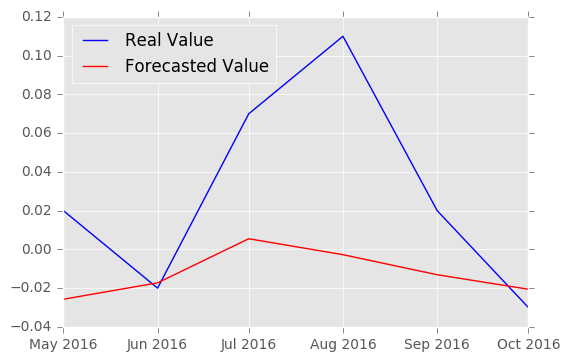

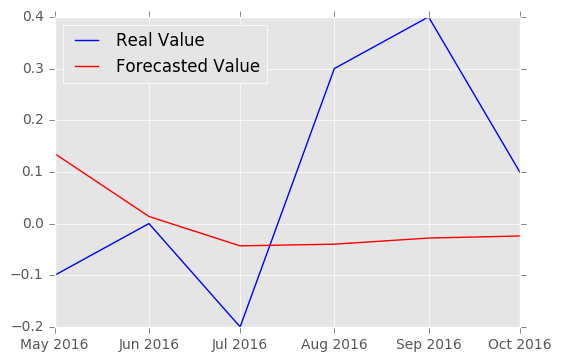

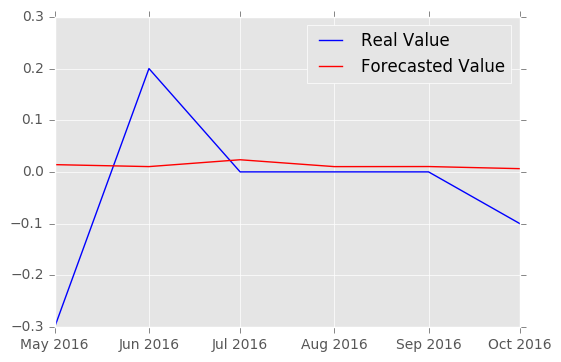

In [49]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])

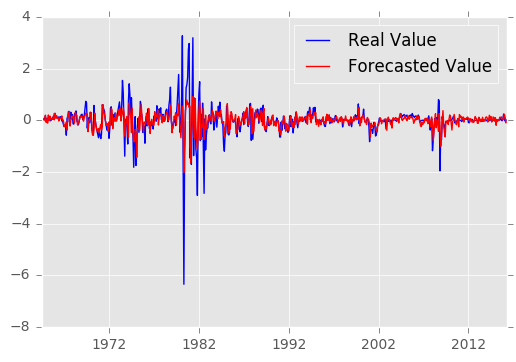

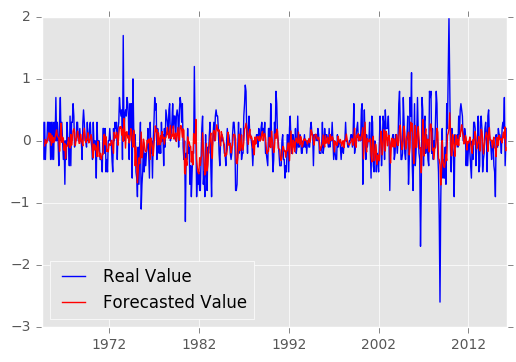

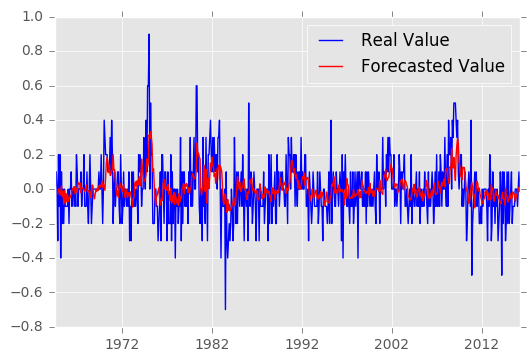

In [50]:
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

In [51]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))

{'rmse': 0.17685320306083832, 'mae': 0.15228527091443533, 'mse': 0.031277055432878113}
{'rmse': 0.33014546500516617, 'mae': 0.30074257242182895, 'mse': 0.10899602806347741}
{'rmse': 0.20998056820535713, 'mae': 0.19781446481744425, 'mse': 0.044091839023844635}


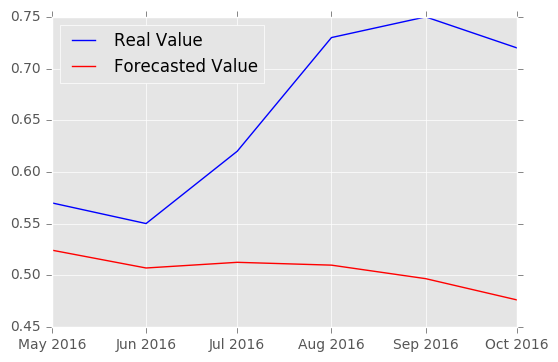

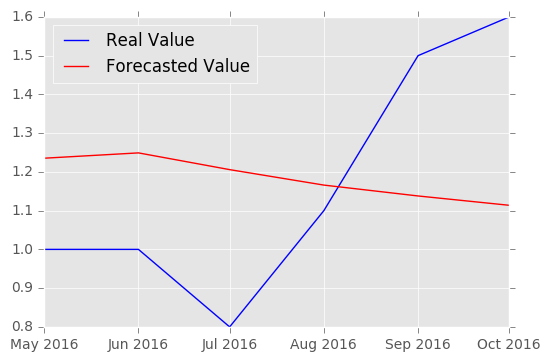

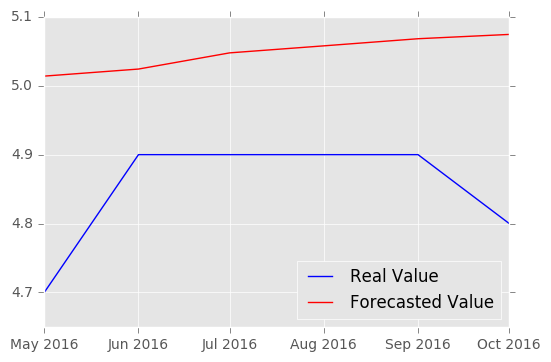

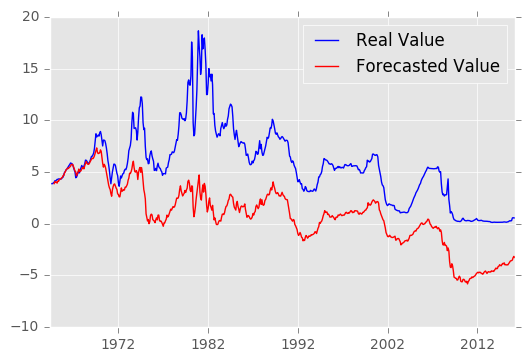

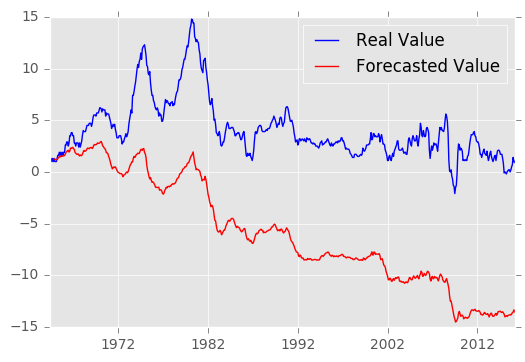

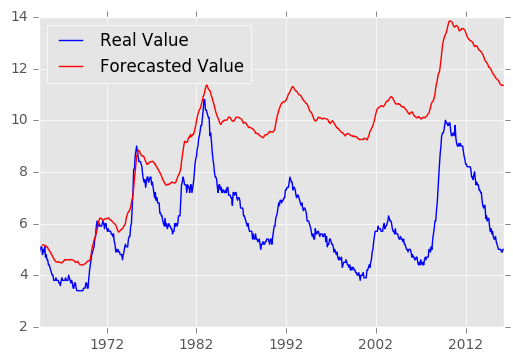

In [52]:
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск модели

In [53]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [54]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=6, model=nn, 
                     years=train_nn_y.index, 
                     epoch=150)

Epoch 1/150
1s - loss: 0.2063
Epoch 2/150
0s - loss: 0.1680
Epoch 3/150
0s - loss: 0.1650
Epoch 4/150
0s - loss: 0.1614
Epoch 5/150
0s - loss: 0.1583
Epoch 6/150
0s - loss: 0.1541
Epoch 7/150
0s - loss: 0.1512
Epoch 8/150
0s - loss: 0.1485
Epoch 9/150
0s - loss: 0.1459
Epoch 10/150
0s - loss: 0.1440
Epoch 11/150
0s - loss: 0.1423
Epoch 12/150
0s - loss: 0.1409
Epoch 13/150
0s - loss: 0.1407
Epoch 14/150
0s - loss: 0.1402
Epoch 15/150
0s - loss: 0.1397
Epoch 16/150
0s - loss: 0.1395
Epoch 17/150
0s - loss: 0.1395
Epoch 18/150
0s - loss: 0.1379
Epoch 19/150
0s - loss: 0.1380
Epoch 20/150
0s - loss: 0.1378
Epoch 21/150
0s - loss: 0.1379
Epoch 22/150
0s - loss: 0.1377
Epoch 23/150
0s - loss: 0.1378
Epoch 24/150
0s - loss: 0.1372
Epoch 25/150
0s - loss: 0.1374
Epoch 26/150
0s - loss: 0.1371
Epoch 27/150
0s - loss: 0.1360
Epoch 28/150
0s - loss: 0.1355
Epoch 29/150
0s - loss: 0.1363
Epoch 30/150
0s - loss: 0.1365
Epoch 31/150
0s - loss: 0.1357
Epoch 32/150
0s - loss: 0.1364
Epoch 33/150
0s -

In [55]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'rmse': 0.085420846250057678, 'mae': 0.074975109895070391, 'mse': 0.0072967209740759939}
{'rmse': 0.22573940431681302, 'mae': 0.2007422630985578, 'mse': 0.050958278661309586}
{'rmse': 0.14972400167540298, 'mae': 0.10196127593517312, 'mse': 0.022417276677696076}


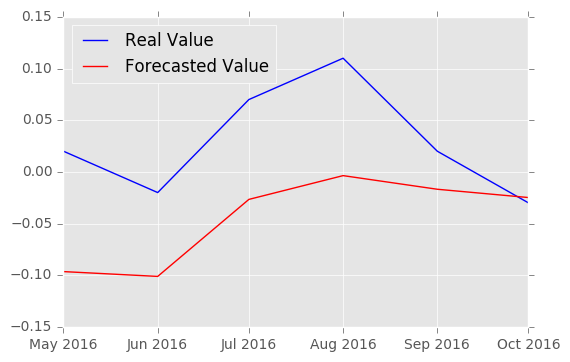

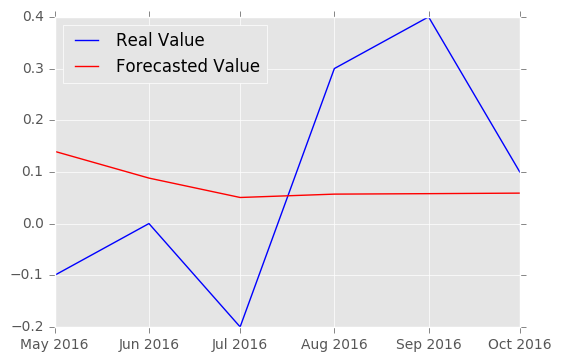

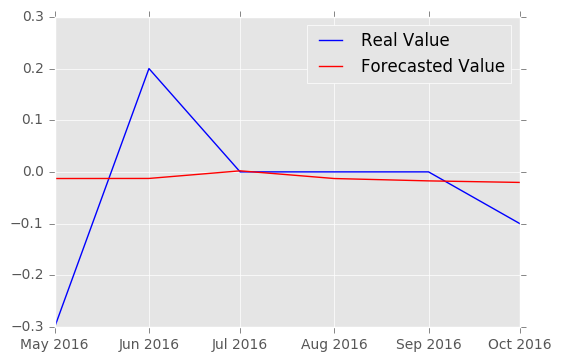

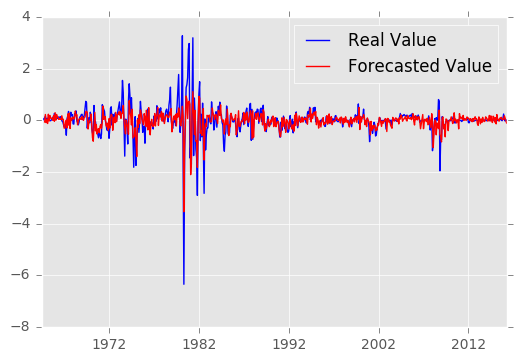

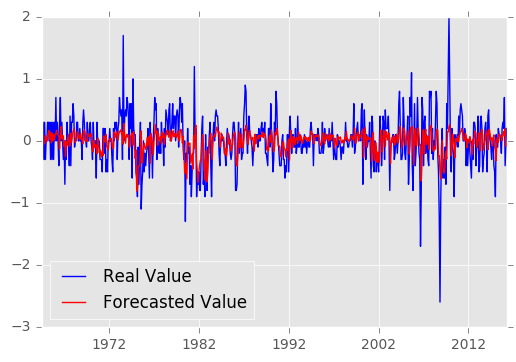

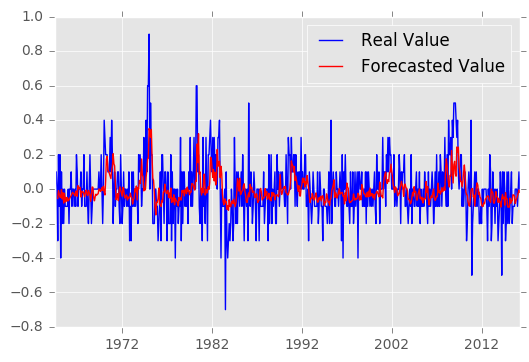

In [56]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

{'rmse': 0.34070634132791178, 'mae': 0.31674116343259806, 'mse': 0.11608081102105151}
{'rmse': 0.31985459593971022, 'mae': 0.25597249617179235, 'mse': 0.10230696254375528}
{'rmse': 0.13898639184108752, 'mae': 0.11233095725377377, 'mse': 0.019317217117004317}


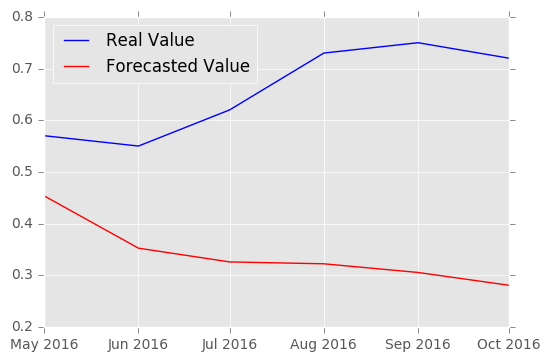

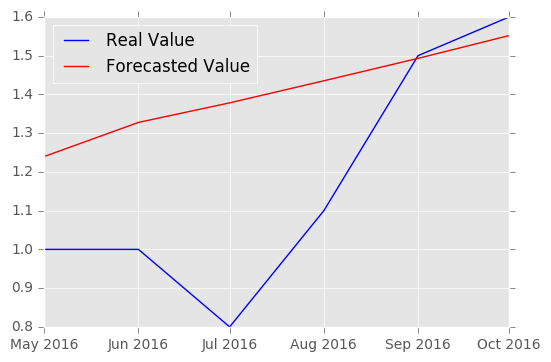

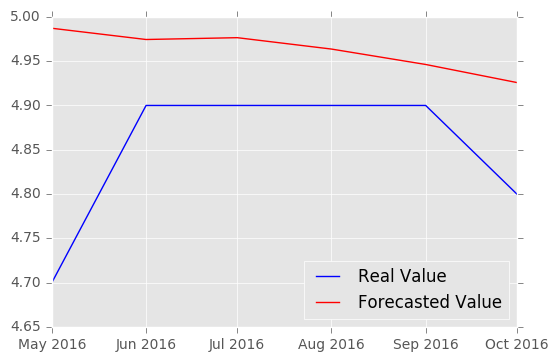

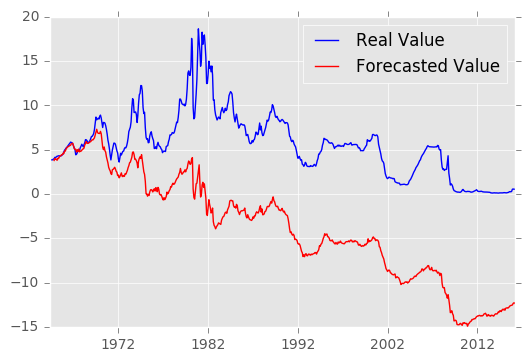

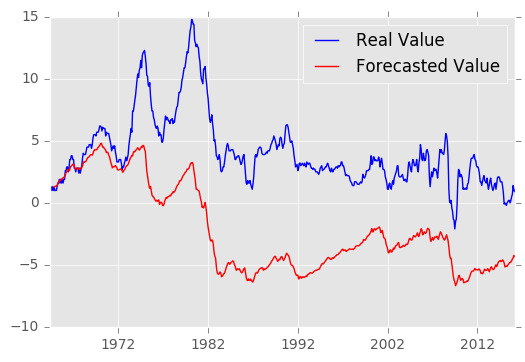

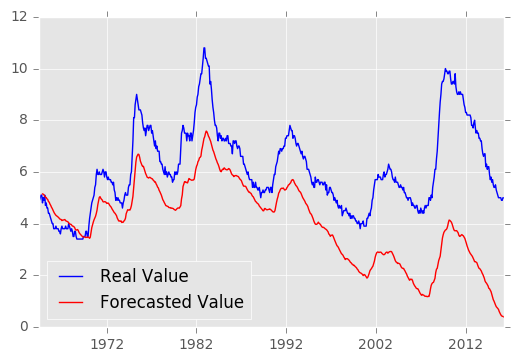

In [57]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

### Hybrid

In [58]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    train_nn_x = df_nn.iloc[:, n_feat:].copy()
    train_nn_y = df_nn.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    
    hybrid_result = pd.DataFrame(var_result + nn_result.as_matrix())
    hybrid_result.columns = train.columns
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(1, steps+1)]
        hybrid_result.index = ind
    return hybrid_result

In [59]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [60]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.1541
Epoch 2/10
0s - loss: 0.1393
Epoch 3/10
0s - loss: 0.1391
Epoch 4/10
0s - loss: 0.1397
Epoch 5/10
0s - loss: 0.1387
Epoch 6/10
0s - loss: 0.1380
Epoch 7/10
0s - loss: 0.1386
Epoch 8/10
0s - loss: 0.1387
Epoch 9/10
0s - loss: 0.1372
Epoch 10/10
0s - loss: 0.1383


Первый запуск

In [61]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'rmse': 0.059538040533724433, 'mae': 0.050735118388857775, 'mse': 0.0035447782705954139}
{'rmse': 0.25282901939530017, 'mae': 0.2140385160403423, 'mse': 0.063922513048389057}
{'rmse': 0.15313768886986864, 'mae': 0.1091985879662718, 'mse': 0.023451151752404687}


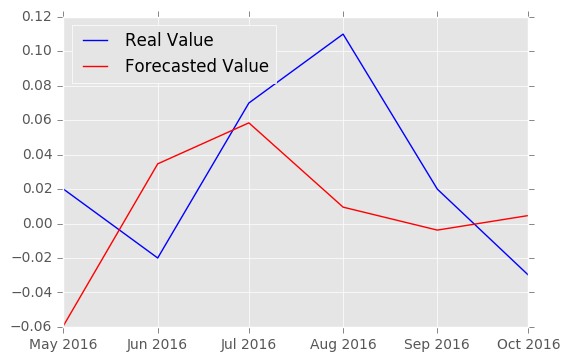

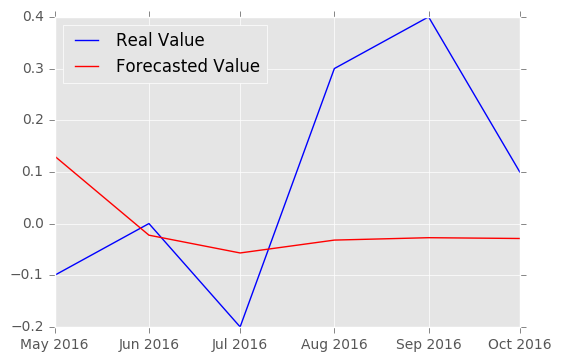

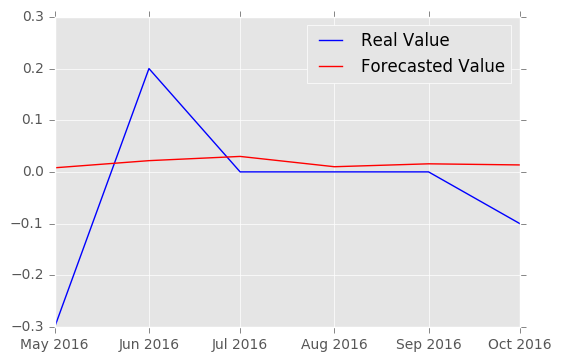

In [62]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'rmse': 0.10677177333443333, 'mae': 0.093799466540050669, 'mse': 0.011400211580979607}
{'rmse': 0.33549706661097822, 'mae': 0.29231003899027969, 'mse': 0.11255828170457115}
{'rmse': 0.21962014798772952, 'mae': 0.20845436179233637, 'mse': 0.048233009402152215}


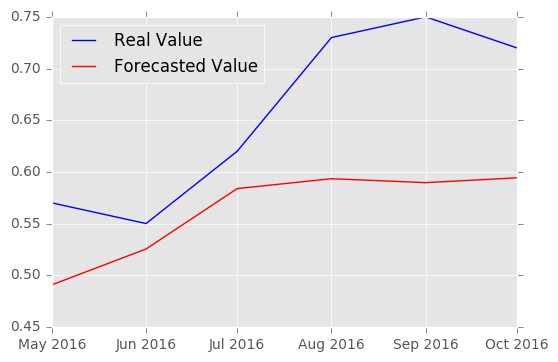

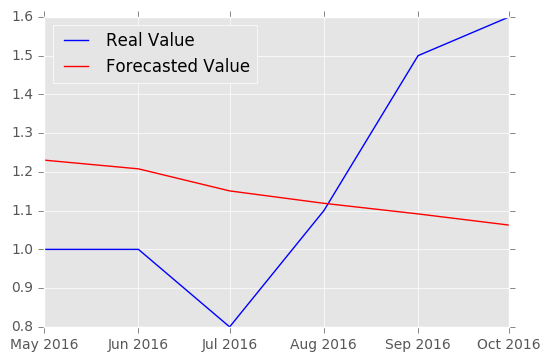

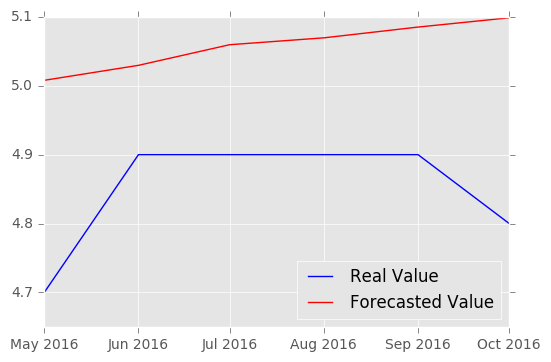

In [63]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.1403
Epoch 2/10
0s - loss: 0.1394
Epoch 3/10
0s - loss: 0.1391
Epoch 4/10
0s - loss: 0.1377
Epoch 5/10
1s - loss: 0.1390
Epoch 6/10
0s - loss: 0.1381
Epoch 7/10
0s - loss: 0.1382
Epoch 8/10
0s - loss: 0.1383
Epoch 9/10
0s - loss: 0.1378
Epoch 10/10
0s - loss: 0.1378


In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'rmse': 0.050801122719089507, 'mae': 0.041777686190869218, 'mse': 0.002580754069519992}
{'rmse': 0.24950340363618717, 'mae': 0.21011017988070571, 'mse': 0.06225194842604214}
{'rmse': 0.17847934938264023, 'mae': 0.14216496828427769, 'mse': 0.031854878156050564}


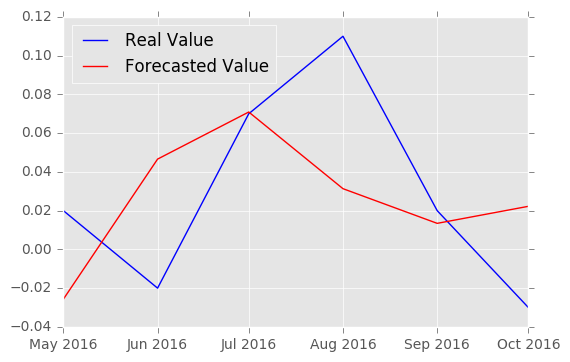

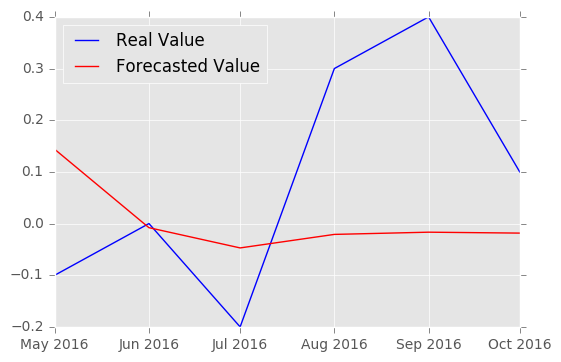

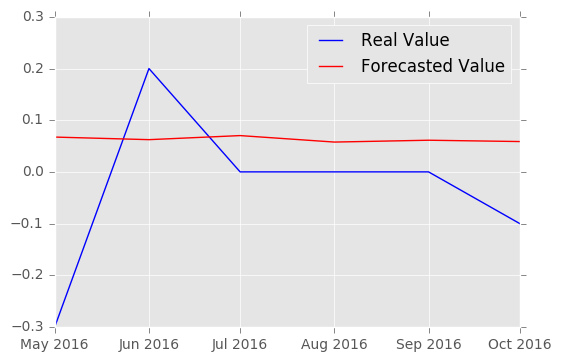

In [66]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'rmse': 0.041597639697867214, 'mae': 0.036647097536205021, 'mse': 0.0017303636284335783}
{'rmse': 0.31912415959360058, 'mae': 0.29204054186642237, 'mse': 0.10184022923632184}
{'rmse': 0.39054686409413447, 'mae': 0.37528705843878835, 'mse': 0.15252685305376235}


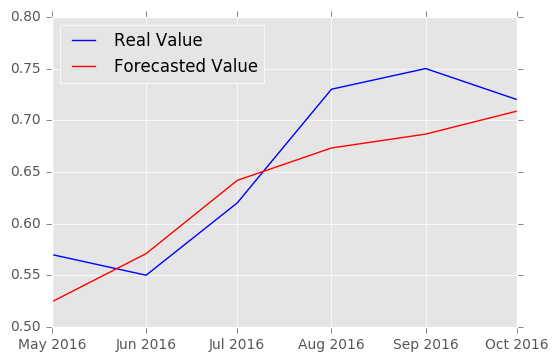

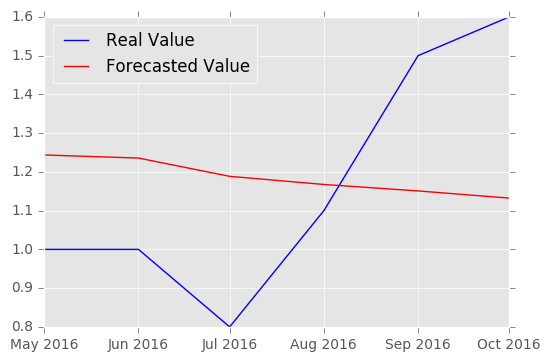

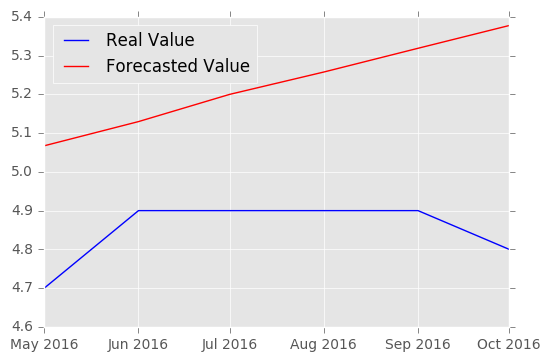

In [67]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.4303
Epoch 2/10
1s - loss: 0.1726
Epoch 3/10
1s - loss: 0.1588
Epoch 4/10
0s - loss: 0.1472
Epoch 5/10
1s - loss: 0.1454
Epoch 6/10
0s - loss: 0.1417
Epoch 7/10
0s - loss: 0.1379
Epoch 8/10
1s - loss: 0.1387
Epoch 9/10
1s - loss: 0.1386
Epoch 10/10
0s - loss: 0.1393


In [69]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'rmse': 0.079278327245083186, 'mae': 0.061904104022633057, 'mse': 0.0062850531707784986}
{'rmse': 0.24558273785763379, 'mae': 0.20840209873130353, 'mse': 0.060310881133651274}
{'rmse': 0.1574035654469049, 'mae': 0.110146462063891, 'mse': 0.024775882415398076}


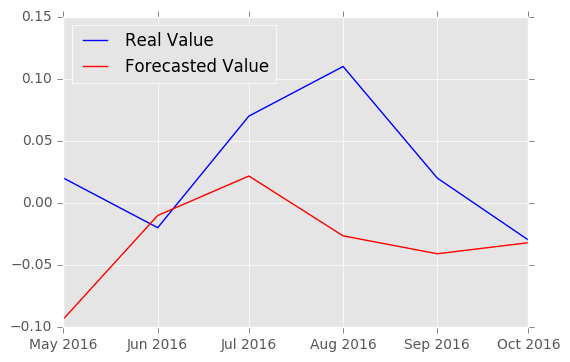

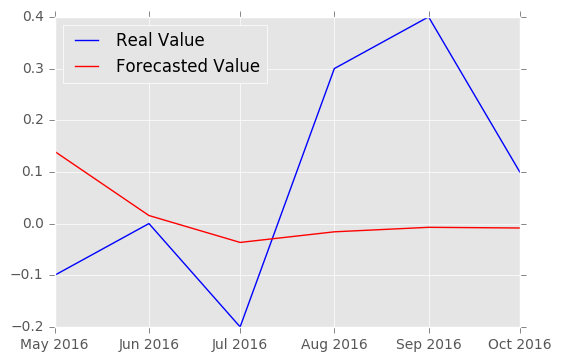

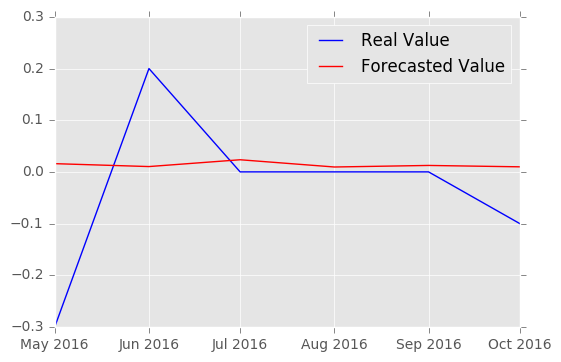

In [70]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'rmse': 0.25035991727481949, 'mae': 0.22656638947589425, 'mse': 0.062680088177854462}
{'rmse': 0.30871600639829389, 'mae': 0.288965179062387, 'mse': 0.095305572606511416}
{'rmse': 0.21300583688576702, 'mae': 0.20071359652559506, 'mse': 0.045371486547405991}


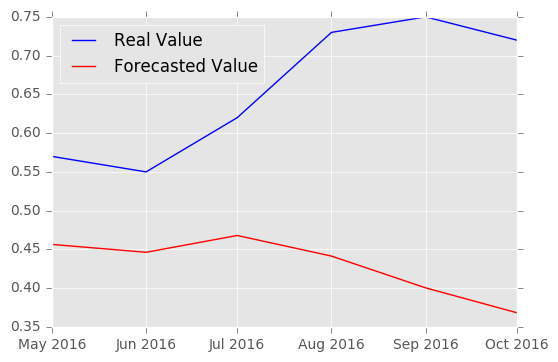

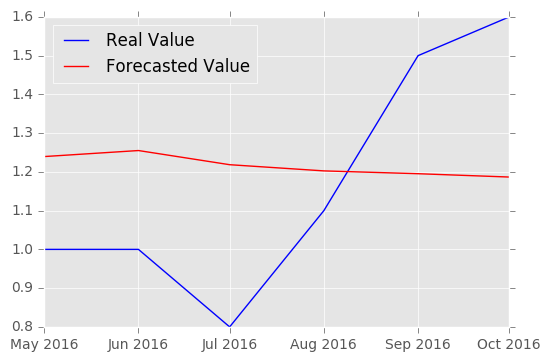

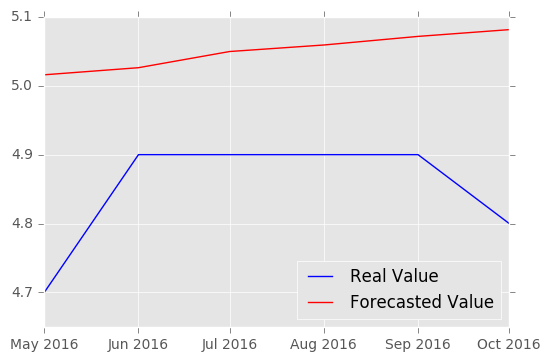

In [71]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

C DropOut 2

In [72]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.3376
Epoch 2/10
1s - loss: 0.1865
Epoch 3/10
1s - loss: 0.1588
Epoch 4/10
0s - loss: 0.1433
Epoch 5/10
1s - loss: 0.1437
Epoch 6/10
0s - loss: 0.1404
Epoch 7/10
1s - loss: 0.1400
Epoch 8/10
1s - loss: 0.1392
Epoch 9/10
1s - loss: 0.1368
Epoch 10/10
1s - loss: 0.1384


{'rmse': 0.18523031249311808, 'mae': 0.16664191486898289, 'mse': 0.034310268666298181}
{'rmse': 0.30225102077401855, 'mae': 0.2873211300673591, 'mse': 0.091355679558936184}
{'rmse': 0.21208428863430837, 'mae': 0.19961691801590767, 'mse': 0.044979745485520618}


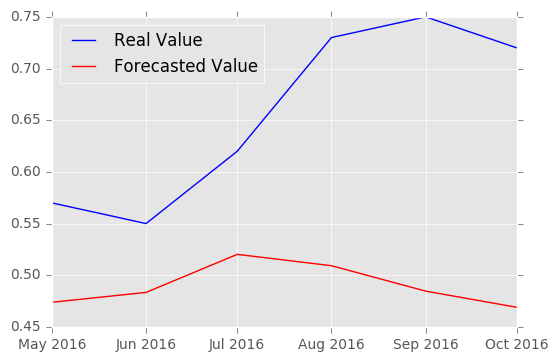

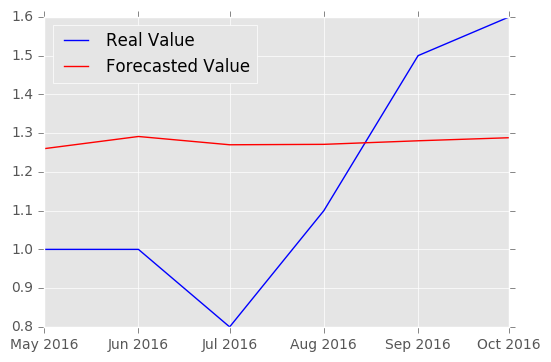

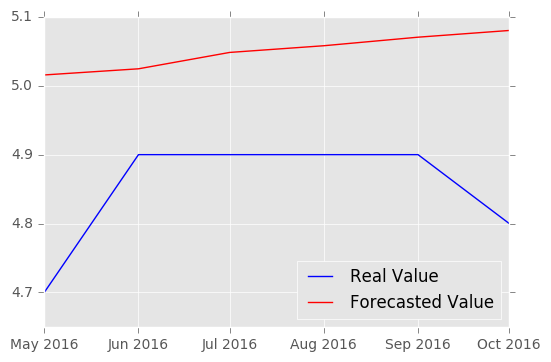

In [73]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid Full

In [74]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [75]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 0.8291
Epoch 2/500
0s - loss: 0.4812
Epoch 3/500
0s - loss: 0.2994
Epoch 4/500
0s - loss: 0.2013
Epoch 5/500
0s - loss: 0.1464
Epoch 6/500
0s - loss: 0.1184
Epoch 7/500
0s - loss: 0.1018
Epoch 8/500
0s - loss: 0.0906
Epoch 9/500
0s - loss: 0.0814
Epoch 10/500
0s - loss: 0.0752
Epoch 11/500
0s - loss: 0.0700
Epoch 12/500
0s - loss: 0.0660
Epoch 13/500
0s - loss: 0.0629
Epoch 14/500
0s - loss: 0.0607
Epoch 15/500
0s - loss: 0.0586
Epoch 16/500
0s - loss: 0.0562
Epoch 17/500
1s - loss: 0.0555
Epoch 18/500
0s - loss: 0.0542
Epoch 19/500
0s - loss: 0.0530
Epoch 20/500
0s - loss: 0.0522
Epoch 21/500
0s - loss: 0.0508
Epoch 22/500
0s - loss: 0.0503
Epoch 23/500
0s - loss: 0.0496
Epoch 24/500
1s - loss: 0.0493
Epoch 25/500
1s - loss: 0.0490
Epoch 26/500
1s - loss: 0.0480
Epoch 27/500
1s - loss: 0.0474
Epoch 28/500
1s - loss: 0.0474
Epoch 29/500
1s - loss: 0.0467
Epoch 30/500
1s - loss: 0.0464
Epoch 31/500
1s - loss: 0.0457
Epoch 32/500
1s - loss: 0.0460
Epoch 33/500
1s -

{'rmse': 4.2700020838451671, 'mae': 4.2655169745924821, 'mse': 18.23291779604207}
{'rmse': 1.1652427322652332, 'mae': 1.0763586352164423, 'mse': 1.3577906250969463}
{'rmse': 0.28533067199370599, 'mae': 0.27651164357558367, 'mse': 0.081413592380379832}


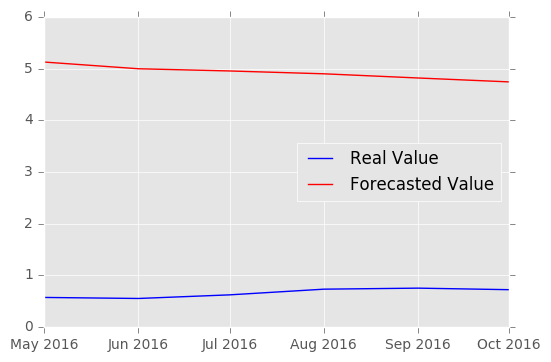

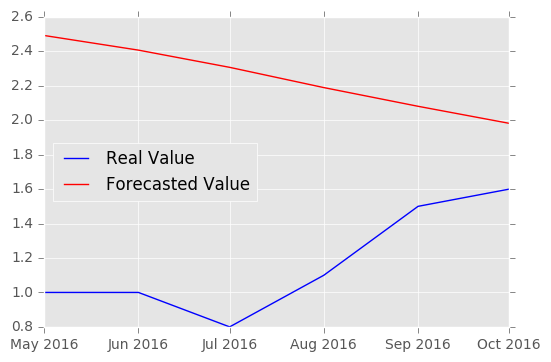

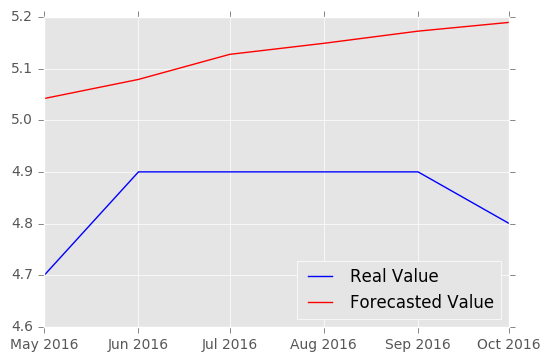

In [76]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [77]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 0.8301
Epoch 2/500
1s - loss: 0.5112
Epoch 3/500
1s - loss: 0.3162
Epoch 4/500
1s - loss: 0.2329
Epoch 5/500
1s - loss: 0.1768
Epoch 6/500
1s - loss: 0.1350
Epoch 7/500
1s - loss: 0.1070
Epoch 8/500
1s - loss: 0.0894
Epoch 9/500
1s - loss: 0.0790
Epoch 10/500
1s - loss: 0.0721
Epoch 11/500
1s - loss: 0.0671
Epoch 12/500
1s - loss: 0.0637
Epoch 13/500
1s - loss: 0.0614
Epoch 14/500
1s - loss: 0.0593
Epoch 15/500
1s - loss: 0.0573
Epoch 16/500
1s - loss: 0.0557
Epoch 17/500
1s - loss: 0.0547
Epoch 18/500
1s - loss: 0.0538
Epoch 19/500
1s - loss: 0.0529
Epoch 20/500
1s - loss: 0.0512
Epoch 21/500
1s - loss: 0.0508
Epoch 22/500
1s - loss: 0.0494
Epoch 23/500
1s - loss: 0.0495
Epoch 24/500
1s - loss: 0.0490
Epoch 25/500
1s - loss: 0.0484
Epoch 26/500
1s - loss: 0.0478
Epoch 27/500
1s - loss: 0.0468
Epoch 28/500
1s - loss: 0.0467
Epoch 29/500
1s - loss: 0.0469
Epoch 30/500
1s - loss: 0.0464
Epoch 31/500
1s - loss: 0.0454
Epoch 32/500
1s - loss: 0.0452
Epoch 33/500
1s -

{'rmse': 4.2888674428298268, 'mae': 4.2820026068538475, 'mse': 18.394383942165657}
{'rmse': 1.3912455110810664, 'mae': 1.3569383831405226, 'mse': 1.9355640721032177}
{'rmse': 0.18011705332289196, 'mae': 0.16496444511468411, 'mse': 0.03244215289772151}


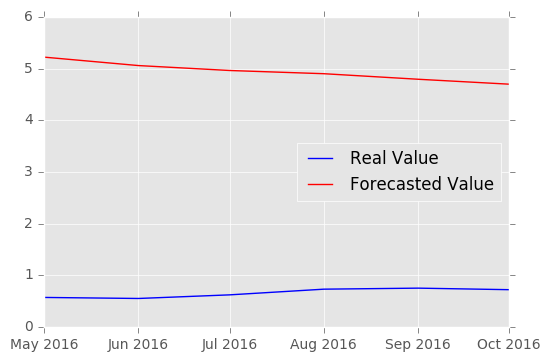

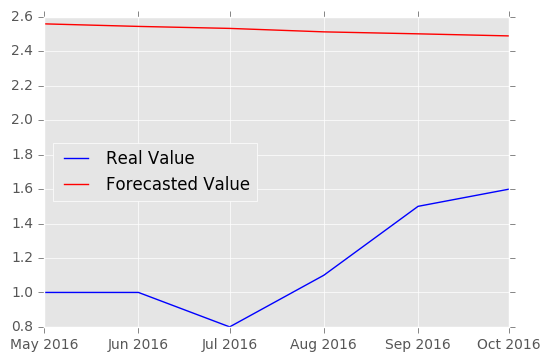

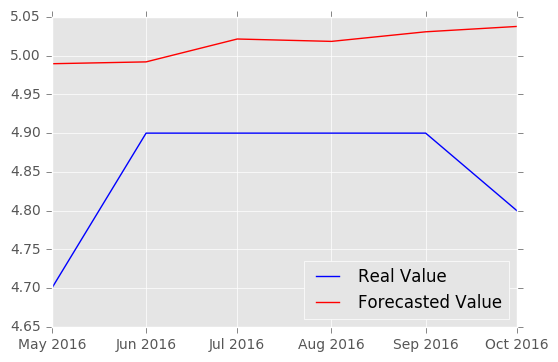

In [78]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [79]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
2s - loss: 1.1372
Epoch 2/500
1s - loss: 0.9747
Epoch 3/500
1s - loss: 0.9027
Epoch 4/500
1s - loss: 0.8408
Epoch 5/500
1s - loss: 0.7604
Epoch 6/500
1s - loss: 0.7092
Epoch 7/500
1s - loss: 0.6862
Epoch 8/500
1s - loss: 0.6656
Epoch 9/500
1s - loss: 0.6800
Epoch 10/500
1s - loss: 0.6358
Epoch 11/500
1s - loss: 0.6427
Epoch 12/500
1s - loss: 0.6325
Epoch 13/500
1s - loss: 0.6294
Epoch 14/500
1s - loss: 0.6080
Epoch 15/500
1s - loss: 0.6306
Epoch 16/500
1s - loss: 0.5843
Epoch 17/500
1s - loss: 0.5921
Epoch 18/500
1s - loss: 0.6052
Epoch 19/500
1s - loss: 0.5513
Epoch 20/500
1s - loss: 0.5550
Epoch 21/500
1s - loss: 0.5765
Epoch 22/500
1s - loss: 0.5179
Epoch 23/500
1s - loss: 0.5478
Epoch 24/500
1s - loss: 0.5619
Epoch 25/500
1s - loss: 0.5475
Epoch 26/500
1s - loss: 0.5105
Epoch 27/500
1s - loss: 0.5638
Epoch 28/500
1s - loss: 0.5201
Epoch 29/500
1s - loss: 0.5321
Epoch 30/500
1s - loss: 0.5140
Epoch 31/500
1s - loss: 0.5333
Epoch 32/500
1s - loss: 0.5035
Epoch 33/500
1s -

{'rmse': 2.4744056030842678, 'mae': 2.4606978957026686, 'mse': 6.1226830885748198}
{'rmse': 1.1043423858944401, 'mae': 1.0488108598154111, 'mse': 1.2195721052830244}
{'rmse': 0.19193882602882198, 'mae': 0.17677484068023416, 'mse': 0.036840512937322385}


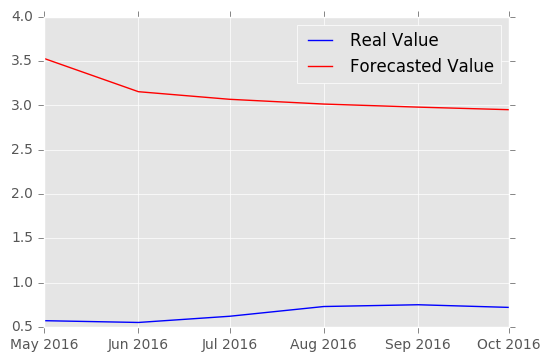

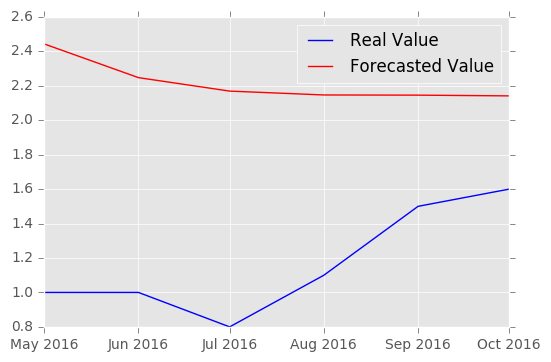

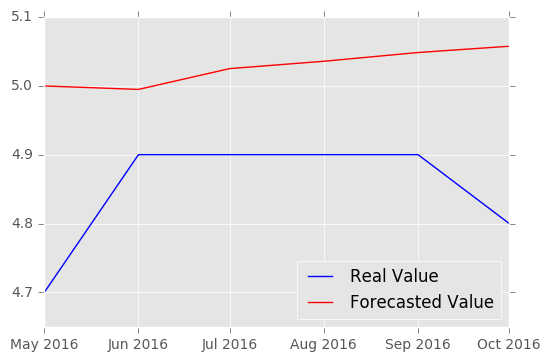

In [80]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])